In [33]:
pip install twilio

     ---------------------------------------- 1.9/1.9 MB 10.7 MB/s eta 0:00:00
     -------------------------------------- 442.2/442.2 kB 9.2 MB/s eta 0:00:00
     ---------------------------------------- 92.7/92.7 kB ? eta 0:00:00
     ---------------------------------------- 63.8/63.8 kB ? eta 0:00:00
     ---------------------------------------- 45.2/45.2 kB ? eta 0:00:00
     ---------------------------------------- 51.6/51.6 kB ? eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\Scripts\python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("health_monitoring.csv")

# Convert Timestamp to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Sort the data by Timestamp
df = df.sort_values(by='Timestamp')

# Split Blood Pressure into Systolic and Diastolic
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.extract(r'(\d+)/(\d+)').astype(float)

# Select only numerical columns for model input
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
df_numeric = df[features]

# Normalize using Min-Max Scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(df_numeric)

# Create a DataFrame from normalized data
df_normalized = pd.DataFrame(normalized_data, columns=features)

# Show the normalized data
print(df_normalized.head())



   Heart Rate  Systolic BP  Diastolic BP  Glucose Levels  \
0    0.983333        0.600      0.333333          0.7250   
1    0.633333        0.875      0.133333          0.2250   
2    0.250000        0.800      1.000000          0.0625   
3    0.866667        0.750      0.400000          0.4875   
4    0.116667        0.700      0.500000          0.0250   

   Oxygen Saturation (SpO₂%)  
0                        0.6  
1                        0.6  
2                        0.0  
3                        0.3  
4                        0.6  


In [12]:
# Create a binary target from the original df
df_normalized['Alert'] = df['Alert Triggered (Yes/No)'].map({'Yes': 1, 'No': 0}).values

# Drop Timestamp from the original df before normalization (if you need to keep things aligned)
# or just skip this drop if it wasn't added to df_normalized

# Prepare the time-series data
data = df_normalized.values

sequence_length = 10
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length, :-1])  # exclude 'Alert'
    y.append(data[i+sequence_length, -1])     # target is Alert after the window

X = np.array(X)
y = np.array(y)

print(f"Input shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")


Input shape (X): (9990, 10, 5)
Target shape (y): (9990,)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define model
model = Sequential([
    LSTM(64, input_shape=(10, 5), return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2)


Epoch 1/20


C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7068 - loss: 0.6078 - val_accuracy: 0.7317 - val_loss: 0.5830
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7340 - loss: 0.5840 - val_accuracy: 0.7317 - val_loss: 0.5827
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7464 - loss: 0.5729 - val_accuracy: 0.7317 - val_loss: 0.5828
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7358 - loss: 0.5807 - val_accuracy: 0.7317 - val_loss: 0.5824
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7474 - loss: 0.5674 - val_accuracy: 0.7317 - val_loss: 0.5822
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7409 - loss: 0.5759 - val_accuracy: 0.7317 - val_loss: 0.5822
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7436 - loss: 0.5730 - val_accuracy: 0.7317 - val_loss: 0.5828
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7355 - loss: 0.5798 - val_accuracy: 0.7317 - val_

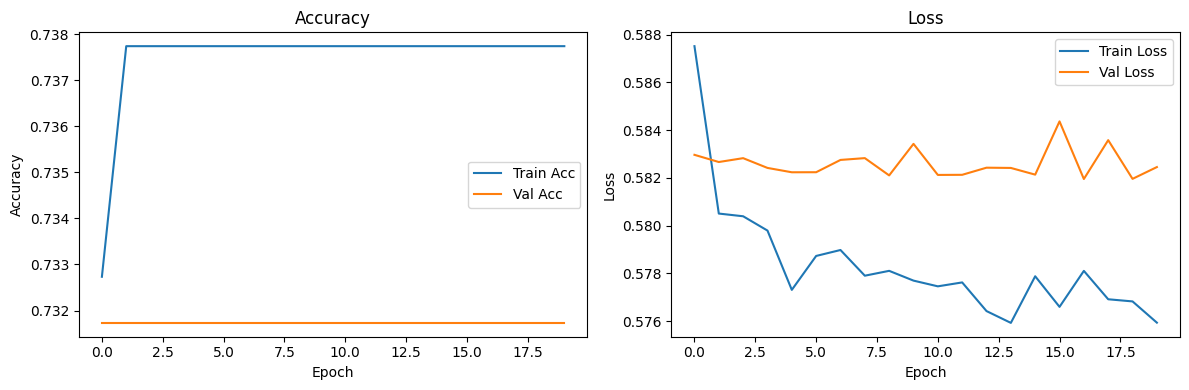

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7368 - loss: 0.5760
Final Accuracy: 0.7365, Loss: 0.5766
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
 [[   0 2632]
 [   0 7358]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2632
         1.0       0.74      1.00      0.85      7358

    accuracy                           0.74      9990
   macro avg       0.37      0.50      0.42      9990
weighted avg       0.54      0.74      0.62      9990



C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [17]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on full set (or split test set if available)
loss, accuracy = model.evaluate(X, y)
print(f"Final Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predictions
y_pred = model.predict(X) > 0.5

# Confusion matrix
cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
print("\nClassification Report:\n", classification_report(y, y_pred))


In [31]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load a few rows (simulate live input)
new_data = pd.read_csv('health_monitoring.csv').tail(10)  # Simulated latest entries

# Split systolic and diastolic if format is '120/80'
bp_split = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')

# Where BP is in 'mmHg', extract number only
bp_single = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')

# Fill in systolic from either format
new_data['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')

# Fill in diastolic from split format or 0 if missing
new_data['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Define features for scaling
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']

# Scale features
scaler = MinMaxScaler()
X_new_scaled = scaler.fit_transform(new_data[features])
X_new_seq = []

# Create time windows (assuming 10-timestep window)
for i in range(len(X_new_scaled) - 9):
    X_new_seq.append(X_new_scaled[i:i+10])

X_new_seq = np.array(X_new_seq)

# Predict
predictions = model.predict(X_new_seq)
alerts = (predictions > 0.5).astype(int)
print("Predicted Alert Flags:", alerts.flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted Alert Flags: [1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


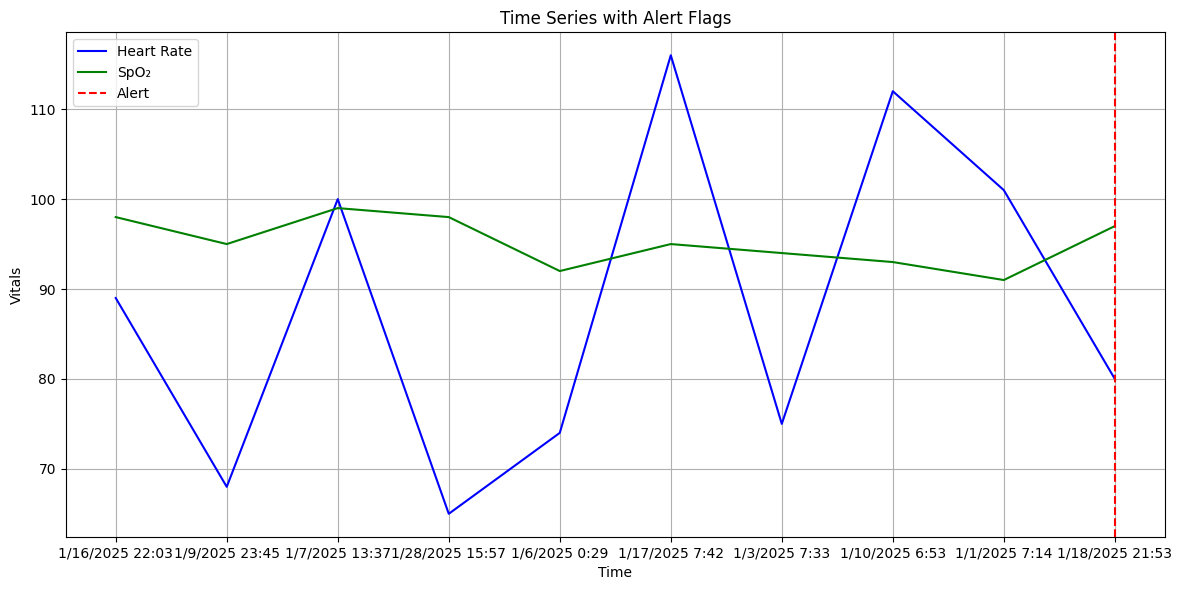

⚠️ Real Alert Triggered!
⚠️ Real Alert Triggered!
SMS sent: SM0b0c840a59569cfe8eb6c93996f88f7f


In [38]:
import matplotlib.pyplot as plt

# Load full data
full_data = pd.read_csv('health_monitoring.csv')

# Extract last 10 rows (used in prediction)
new_data = full_data.tail(10).reset_index(drop=True)

# Create timestamp column if missing
if 'Timestamp' not in new_data.columns:
    new_data['Timestamp'] = pd.date_range(end=pd.Timestamp.now(), periods=10, freq='T')

# Preprocess Blood Pressure
bp_split = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)/(?P<Diastolic>\d+)')
bp_single = new_data['Blood Pressure'].str.extract(r'(?P<Systolic>\d+)\s*mmHg')
new_data['Systolic BP'] = pd.to_numeric(bp_split['Systolic'].fillna(bp_single['Systolic']), errors='coerce')
new_data['Diastolic BP'] = pd.to_numeric(bp_split['Diastolic'].fillna(0), errors='coerce')

# Normalize
features = ['Heart Rate', 'Systolic BP', 'Diastolic BP', 'Glucose Levels', 'Oxygen Saturation (SpO₂%)']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(new_data[features])

# Sequence for model
X_seq = np.array([X_scaled])

# Predict
predictions = model.predict(X_seq)
alerts = (predictions > 0.5).astype(int)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(new_data['Timestamp'], new_data['Heart Rate'], label='Heart Rate', color='blue')
plt.plot(new_data['Timestamp'], new_data['Oxygen Saturation (SpO₂%)'], label='SpO₂', color='green')

if alerts[0][0] == 1:
    plt.axvline(x=new_data['Timestamp'].iloc[-1], color='red', linestyle='--', label='Alert')

plt.title("Time Series with Alert Flags")
plt.xlabel("Time")
plt.ylabel("Vitals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("⚠️ Real Alert Triggered!" if alerts[0][0] == 1 else "✅ All Clear")



#twillow alert/////////////////

from twilio.rest import Client

def send_alert_sms(to_number, heart_rate, spo2):
    account_sid = 'ACb1a03aeb9b81fadc8f8931810197d384'
    auth_token = 'ddcea90f35c93836065f88cbfeec29ac'
    client = Client(account_sid, auth_token)

    message_body = f"⚠️ Health Alert!\nHeart Rate: {heart_rate} bpm\nSpO₂: {spo2}%"

    message = client.messages.create(
        body=message_body,
        from_='+18653916889',
        to=to_number
    )

    print(f"SMS sent: {message.sid}")

if alert == 1:
    print("⚠️ Real Alert Triggered!")
    send_alert_sms('+918270120006', new_data['Heart Rate'].iloc[i+9], new_data['Oxygen Saturation (SpO₂%)'].iloc[i+9])



